# lora data processing

In [1]:
import pathlib
import numpy as np
import more_itertools as mit
import re

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

from tqdm.notebook import trange, tqdm

## functions

In [10]:
## utility functions

def glob_files(path, pattern=r'**/*.dat'):
    yield from (file for file in data_dir.glob('**/*.dat'))
    

def _extract_digit(pattern, text):
    """ helper for extract_bw_and_sf """
    try:
        match = int(re.search(pattern, text)[1])
    except:
        print('ERROR! unable to extract bw or sf')
        return 
    else:
        return match 
    
    
def extract_bw_and_sf(filename, BW_val):
    """ extracts params from input filename """
    _bw_pattern, _sf_pattern = r'BW(\d)', r'SF(\d{1,})'
    
    bw_match = _extract_digit(_bw_pattern, filename)
    if bw_match is not None:
        bw_match = BW_val[bw_match - 1]
    
    sf_match = _extract_digit(_sf_pattern, filename)
    
    return bw_match, sf_match

def check_and_load_file(filepath):
    filepath = pathlib.Path(filepath)
    
    if not isinstance(filepath, pathlib.Path) or not filepath.exists():
        print(f'ERROR! unable to find input file at:\n{filepath}')
        return
        
    return filepath

## get encoding parameters

def get_and_set_encoding_params(filepath):
    BW_val = np.array([10.4e3, 15.6e3, 0, 0, 0, 0, 125e3, 250e3, 500e3])
    BW, SF = extract_bw_and_sf(filepath.name, BW_val) 
    
    Fs = int(1e6)
    sampPerSym = np.round(((2**SF)/BW)*Fs)
    pcktLen = 30.25*sampPerSym

    print(f'BW: {BW} | SF: {SF} | Fs: {Fs} | Samples Per Symbol: {sampPerSym} | Packet Length: {pcktLen}')

## load data

def load_data(filepath):
    try:
        signal = np.fromfile(filepath, dtype=np.complex64)
    except Exception as exc:
        print(f'unable to load file:\n{exc}')
        return 
    else:
        print(f'loaded signal with {signal.size} samples')
        return signal

## normalize signal

def normalize_signal(signal, th=0.001):
    real_s = np.abs(np.real(signal)) 
    
    norm_s = np.array([
        np.ceil(val) if val >= th else 0
        for val in real_s
    ])
    return real_s, norm_s

### locate zero indices

def _locate_zero_indices(norm_signal):
    indices = np.where(norm_signal == 0.0)[0]
    
    return indices

### find consecutive groups 

def _find_consecutive_groups(zero_indexes):
    groups = [
        list(j) for j in 
        mit.consecutive_groups(sorted(list(set(zero_indexes))))
    ]
    
    lengths = np.array(
        [len(item) for item in groups]
    )
    
    print(f'found {len(groups)} groups')
    return groups, lengths

### locate endpoints

def _locate_endpoints(groups, threshold=15_000):
    all_endpoints = [
        endpoints for group in groups
            if len(group) > threshold
        for endpoints in (group[0], group[1])
    ]
    
    endpoint_pairs = [
        (start, stop) 
        for start, stop in zip(all_endpoints[1::2], all_endpoints[2::2])
    ]
    
    print(f'extracted {len(endpoint_pairs)} packets from signal')
    return endpoint_pairs

## extract endpoints

def plot_groups(indexes, lengths, filename):
    fig, axs = plt.subplots(2)
    fig.suptitle(f'{filename}')
    axs[0].plot(indexes)
    axs[1].plot(lengths)
    
    plt.savefig(f'plots/{filename}.png')
    return fig

def extract_endpoints(normalized_signal, filename, threshold=15_000):
    zero_indexes = _locate_zero_indices(normalized_signal)
    consec_groups, groups_lengths = _find_consecutive_groups(zero_indexes)
    
    # validation plot 
    plot_groups(zero_indexes, groups_lengths, filename)
    
    endpoint_pairs = _locate_endpoints(consec_groups, threshold)
    return endpoint_pairs



## packet slicing

def _slice_and_pad(signal, endpoints, length):
    start, stop = endpoints
    sliced = signal[start:stop] 
    
    if len(sliced) < length:
        sliced = np.concatenate((
            sliced, np.zeros(length - len(sliced))
        ))
        
    return sliced


def slice_all_packets(signal, endpoints):
    max_length = max(stop - start for start, stop in endpoint_pairs)
    print(f'got max packet length: {max_length}')
    
    packets = np.vstack(
        tuple(
            _slice_and_pad(real_s, pair, max_length)
            for pair in endpoint_pairs
        )
    )
    
    print(f'extracted {len(packets)} packets from signal')
    return packets
    

## select file

In [3]:
data_dir = pathlib.Path('data')

all_data_files = list(glob_files(data_dir))
all_data_files[:5]

[PosixPath('data/LoRa_Recording_OTA/Location2/lora_BW8_SF12_915MHz_1Msps_L2.dat'),
 PosixPath('data/LoRa_Recording_OTA/Location2/lora_BW8_SF11_915MHz_1Msps_L2.dat'),
 PosixPath('data/LoRa_Recording_OTA/Location2/lora_BW8_SF10_915MHz_1Msps_L2.dat'),
 PosixPath('data/LoRa_Recording_OTA/Location2/lora_BW1_SF10_915MHz_1Msps_L2.dat'),
 PosixPath('data/LoRa_Recording_OTA/Location2/lora_BW9_SF12_915MHz_1Msps_L2.dat')]

## param dict 

In [4]:
param_dict = {
    # location 0 
    'lora_BW1_SF10_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L0.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L0.dat': 0.001,
    
    # location 1 
    'lora_BW1_SF10_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L1.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L1.dat': 0.001,
    
    # location 2 
    'lora_BW1_SF10_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L2.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L2.dat': 0.001,
    
    # location 3 
    'lora_BW1_SF10_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L3.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L3.dat': 0.001,
    
    # location 4 
    'lora_BW1_SF10_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L4.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L4.dat': 0.001,
    
    # location 5 
    'lora_BW1_SF10_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW1_SF11_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW1_SF12_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW2_SF10_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW2_SF11_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW2_SF12_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW7_SF10_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW7_SF11_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW7_SF12_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW8_SF10_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW8_SF11_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW8_SF12_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW9_SF10_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW9_SF11_915MHz_1Msps_L5.dat': 0.001,
    'lora_BW9_SF12_915MHz_1Msps_L5.dat': 0.001
}

## all together now 

In [11]:
def extract_packets(filepath, norm_thresh=0.001, packet_thresh=15_000):
    filepath = check_and_load_file(filepath)    
    print(f'norm threshold: {norm_thresh}')
    
    get_and_set_encoding_params(filepath) 
    signal = load_data(filepath)
    
    real_s, norm_s = normalize_signal(signal[:3_000_000], norm_thresh)
    endpoint_pairs = extract_endpoints(norm_s, filepath.name, packet_thresh)
    
    all_packets = slice_all_packets(real_s, endpoint_pairs)
    
    return all_packets

norm threshold: 0.001
BW: 250000.0 | SF: 11 | Fs: 1000000 | Samples Per Symbol: 8192.0 | Packet Length: 247808.0
loaded signal with 169481070 samples
found 353773 groups
extracted 10 packets from signal
got max packet length: 266072
extracted 10 packets from signal


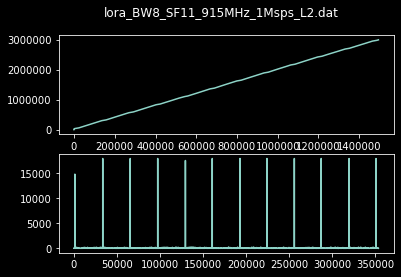

In [12]:
all_packets = extract_packets(all_data_files[1], norm_thresh=0.001, packet_thresh=15_000)

## batch processing

In [ ]:
for file in tqdm(all_data_files):
    print(f'processing {file.name}')
    extract_packets(file, norm_thresh=param_dict[file.name], packet_thresh=15_000)  
    plt.show()
    print('\n\n\n')

## threshold tuning

In [ ]:
plt.hist(real_s[np.where(real_s < 0.005)], bins=50);

In [ ]:
plt.hist(real_s, bins=50);